In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt

Случайный датасет. Точки, лежащие на прямой $y = 0.5x + 2$ с нормально распределённой случайной ошибкой с $\sigma=0.5$.

In [2]:
A = 0.5
B = 2.0
n = 100

x = np.linspace(0,10, n)
y = A*x + B + np.random.normal(scale=.5, size=n)

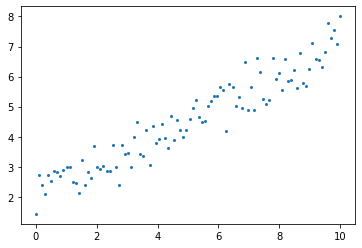

In [3]:
plt.scatter(x,y, s=4)

In [4]:
def mk_model(a,b):
    return lambda x: a*x+b

# Линейная регрессия средствами `linregress`

In [5]:
n = len(x)
lin_model = sps.linregress(x, y)
a,b = lin_model.slope, lin_model.intercept
a_err, b_err = lin_model.stderr, lin_model.intercept_stderr
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

In [6]:
print(f"a = {a:0.4f} ± {a_err:0.4f}, доверительный интервал α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f} ± {b_err:0.4f}, доверительный интервал α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.4979 ± 0.0164, доверительный интервал α=5% [0.4654 - 0.5304]
b = 2.0515 ± 0.0948, доверительный интервал α=5% [1.8633 - 2.2397]


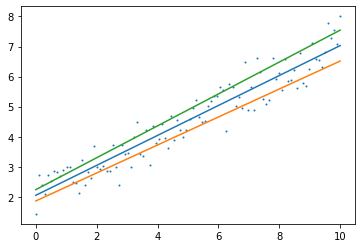

In [7]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(a_conf[0], b_conf[0])(x))
plt.plot(x, mk_model(a_conf[1], b_conf[1])(x))

In [8]:
%timeit -n 1000 -r 5 lin_model = sps.linregress(x, y)

196 µs ± 11.4 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


# Использование `curve_fit`
Линейная модель $y = ax+b$

In [9]:
def linear(x, a,b):
    return a*x+b

Подбор параметров линейной модели методом наименьших квадратов

In [10]:
((a,b), cov) = spo.curve_fit(linear, xdata=x, ydata=y)
a_err, b_err = np.sqrt(np.diag(cov))
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

In [11]:
print(f"a = {a:0.4f} ± {a_err:0.4f}, доверительный интервал α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f} ± {b_err:0.4f}, доверительный интервал α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.4979 ± 0.0164, доверительный интервал α=5% [0.4654 - 0.5304]
b = 2.0515 ± 0.0948, доверительный интервал α=5% [1.8633 - 2.2397]


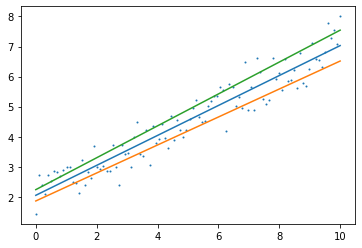

In [12]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(a_conf[0], b_conf[0])(x))
plt.plot(x, mk_model(a_conf[1], b_conf[1])(x))

In [13]:
%timeit -n 1000 -r 5 spo.curve_fit(linear, xdata=x, ydata=y)

251 µs ± 6.21 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


# Прямое вычисление

Случайная составляющая

In [14]:
u = y - (a*x+b)

In [15]:
u_mean, u_sigma = sps.norm.fit(u)
u_mean, u_sigma

(-3.3694663059691265e-10, 0.47300811219710787)

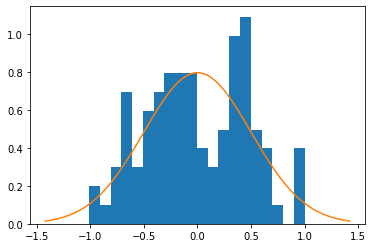

In [16]:
_u = np.linspace(u_mean - u_sigma*3, u_mean + u_sigma*3, 100)
plt.hist(u, bins=20, density=True)

plt.plot(_u, sps.norm(0, 0.5).pdf(_u))

Несмещенная оценка дисперсии случайного члена $u$ $\sigma_u^2 = \frac{1}{n-2}\sum({u_i^2 - \overline{u}^2})$

In [17]:
u_avg = np.mean(u)
sigma_square = 1.0/(n-2)*np.sum((u - u_avg)**2)
sigma_square, sigma_square-u_sigma**2

(0.22830272877986912, 0.004566054575597334)

 $nD[x] = \sum (x-\overline{x})^2$

In [18]:
x_mean = np.mean(x)
dx_square = np.sum((x-x_mean)**2)

Дисперсия $a$: $D[a] = \frac{1}{n}\frac{\sigma_u^2}{D[x]}$

In [19]:
var_a = sigma_square/dx_square

Дисперсия $b$: $D[b] = \sigma_u^2\large[\frac{1}{n} + \frac{\overline{x}^2}{nD[x]}]$

In [20]:
var_b = sigma_square*(1.0/n + np.mean(x)**2/dx_square)

In [21]:
var_a, var_b

(0.00026853825919849955, 0.008996483767761179)

Доверительный интервал для $a$ через $t$ распределение Стьюдента с уровнем значимости $\alpha = 0.05$

In [22]:
conf_a = sps.t.interval(0.95, df = n-2, loc=a, scale=np.sqrt(var_a))
conf_a

(0.46538710502696273, 0.5304265851395891)

Доверительный интервал для $b$ через $t$ распределение Стьюдента с уровнем значимости $\alpha = 0.05$

In [23]:
conf_b = sps.t.interval(0.95, df = n-2, loc = b, scale = np.sqrt(var_b))
conf_b

(1.86325151208882, 2.2397041778303572)

График линейных моделей, соответствующих крайним точкам доверительных интервалов

In [24]:
def mk_model(a,b):
    return lambda x: linear(x, a,b)

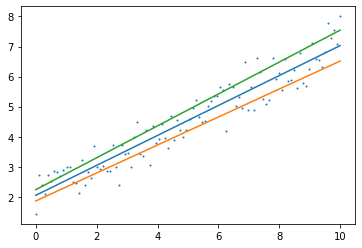

In [25]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(conf_a[0], conf_b[0])(x))
plt.plot(x, mk_model(conf_a[1], conf_b[1])(x))

In [26]:
%%timeit -n 1000 -r 5
sum_x = x.sum()
sum_y = y.sum()
sum_xy = (x*y).sum()
sum_x_sq = (x*x).sum()
a = (n*sum_xy - sum_x*sum_y)/(n*sum_x_sq - sum_x*sum_x)
b = (sum_y*sum_x_sq - sum_x*sum_xy)/(n*sum_x_sq - sum_x*sum_x)

u = y - (a*x+b)
u_avg = np.mean(u)
sigma_square = 1.0/(n-2)*np.sum((u - u_avg)**2)
x_mean = np.mean(x)
dx_square = np.sum((x-x_mean)**2)

a_err = np.sqrt(sigma_square/dx_square)
b_err = np.sqrt(sigma_square*(1.0/n + np.mean(x)**2/dx_square))
a,b,(a_err, b_err)

54.6 µs ± 1.87 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


_всякое разное_

In [27]:
np.diag(cov)/np.array((var_a, var_b)) - 1

array([5.34403699e-09, 2.60959010e-09])

In [28]:
sps.t.ppf(0.25, len(x)-2)*b_err

-0.06421344832401957

In [29]:
(conf_b[1] - conf_b[0])/2

0.18822633287076862

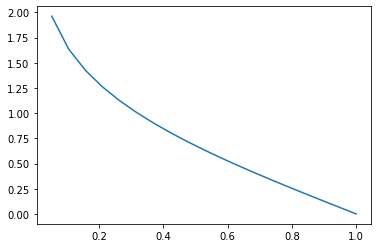

In [30]:
alpha = np.linspace(0,1,20)
plt.plot(alpha, np.abs(sps.t.ppf(alpha/2, n-2)))